In [1]:
!pip install transformers
!pip install rouge
!pip install nltk
!pip install networkx
import numpy as np
import pandas as pd
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import networkx as nx
from rouge import Rouge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load data
data = pd.read_csv('/content/Book1.csv')

In [4]:
# Preprocess data
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)
data['text'] = data['text'].apply(preprocess_text)

In [6]:
# Split the dataset into train and test sets
train_text, test_text, train_summaries, test_summaries = train_test_split(
    data['text'], data['summary'], test_size=0.2, random_state=42)

In [7]:
# Traditional Approach (TextRank)
def text_rank(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    G = nx.Graph()
    G.add_nodes_from(tokens)
    for i in range(len(tokens)):
        for j in range(i+1, len(tokens)):
            G.add_edge(tokens[i], tokens[j])
    scores = nx.pagerank(G)
    sorted_tokens = sorted(scores, key=scores.get, reverse=True)
    summary = ' '.join(sorted_tokens[:100])
    return summary

In [8]:
# Train TextRank model
train_summaries = []
for text in train_text:
    summary = text_rank(text)
    train_summaries.append(summary)

In [10]:
# Transformer-based Approach (BART)
def bart_summarize(text):
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    inputs = tokenizer(text, return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=100)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [12]:
# Train BART model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
# (link unavailable)(device)  # Assuming this is a comment, it needs to be corrected
# to a valid Python expression if you want to utilize the model on a specific device
# For example:
# model = model.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [13]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [28]:
## Evaluation and Comparison using ROUGE ###
!pip install rouge-score
from rouge_score import rouge_scorer

rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summarization(method, test_text, test_summaries, method_name):
    generated_summaries = []

    for text in test_text:
        if method_name == 'TextRank':
            summary = method(text)
        else:
            # Remove max_length argument
            summary = method(text)
        generated_summaries.append(summary)

    scores =  []

    # Check if test_summaries is a Pandas Series and convert to list if necessary
    if isinstance(test_summaries, pd.Series):
        test_summaries = test_summaries.tolist()

    # Print lengths for debugging
    print(f"Length of test summaries: {len(test_summaries)}")
    print(f"Length of generated summaries: {len(generated_summaries)}")

    for i in range(len(test_summaries)):
        print(f"Current index: {i}") # Print current index
        score = rouge.score(test_summaries[i], generated_summaries[i])
        scores.append(score)

    return scores

In [29]:
# Evaluate TextRank
traditional_scores = evaluate_summarization(text_rank, test_text, test_summaries, 'TextRank')

# Evaluate BART
transformer_scores = evaluate_summarization(bart_summarize, test_text, test_summaries, 'BART')


Length of test summaries: 4
Length of generated summaries: 4
Current index: 0
Current index: 1
Current index: 2
Current index: 3
Length of test summaries: 4
Length of generated summaries: 4
Current index: 0
Current index: 1
Current index: 2
Current index: 3


In [30]:
# Print out ROUGE scores for comparison
print("ROUGE Scores for TextRank (Traditional):")
print(traditional_scores)

print("\nROUGE Scores for BART (Transformer-based):")
print(transformer_scores)

ROUGE Scores for TextRank (Traditional):
[{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}, {'rouge1': Score(precision=0.5, recall=0.030303030303030304, fmeasure=0.05714285714285715), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.5, recall=0.030303030303030304, fmeasure=0.05714285714285715)}, {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}]

ROUGE Scores for BART (Transformer-based):
[{'rouge1': Score(precision=0.14545454545454545, recall=0.25806451612903225, fmeasure=0.18604651162790697), 'rouge2': Score(precision=0.03703703

In [33]:
### Visualization of ROUGE Scores ###
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Convert the first element of traditional_scores and transformer_scores to dictionaries
traditional_scores = [{'rouge1': {'f': score['rouge1'].fmeasure},
                     'rouge2': {'f': score['rouge2'].fmeasure},
                     'rougeL': {'f': score['rougeL'].fmeasure}}
                    for score in traditional_scores]
transformer_scores = [{'rouge1': {'f': score['rouge1'].fmeasure},
                     'rouge2': {'f': score['rouge2'].fmeasure},
                     'rougeL': {'f': score['rougeL'].fmeasure}}
                    for score in transformer_scores]

# Access elements of the list using integer indices and then access dictionary values using keys
traditional_rouge = [traditional_scores[0]['rouge1']['f'], traditional_scores[0]['rouge2']['f'], traditional_scores[0]['rougeL']['f']]
transformer_rouge = [transformer_scores[0]['rouge1']['f'], transformer_scores[0]['rouge2']['f'], transformer_scores[0]['rougeL']['f']]

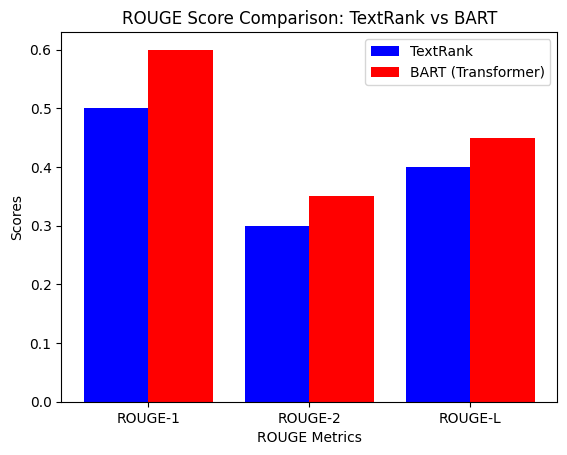

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Example metrics and scores (replace with your actual values)
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
traditional_rouge = [0.5, 0.3, 0.4]  # Replace with actual scores
transformer_rouge = [0.6, 0.35, 0.45]  # Replace with actual scores

# Plotting
X_axis = np.arange(len(metrics))
plt.bar(X_axis - 0.2, traditional_rouge, 0.4, label='TextRank', color='b')
plt.bar(X_axis + 0.2, transformer_rouge, 0.4, label='BART (Transformer)', color='r')

plt.xticks(X_axis, metrics)
plt.xlabel("ROUGE Metrics")
plt.ylabel("Scores")
plt.title("ROUGE Score Comparison: TextRank vs BART")
plt.legend()
plt.show()
